# Building prediction Model of the total delivery duration seconds

In [1]:
import pandas as pd
from collections import Counter

In [2]:
df = pd.read_csv("historical_data.csv")
print("Data shape:", df.shape)

Data shape: (197428, 9)


In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,subtotal,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,3441,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,1900,1.0,2.0,2.0,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,1900,1.0,0.0,0.0,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,6900,1.0,1.0,2.0,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,3900,6.0,6.0,9.0,650.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 9 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   subtotal                                      197428 non-null  int64  
 5   total_onshift_dashers                         181166 non-null  float64
 6   total_busy_dashers                            181166 non-null  float64
 7   total_outstanding_orders                      181166 non-null  float64
 8   estimated_store_to_consumer_driving_duration  196902 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 

## Create target column

#### Discard rows with invalid creation and delivery times. Convert datetime to PDT.

In [5]:
df = df[ (~df.created_at.isnull()) & (~df.actual_delivery_time.isnull()) ]
print("Valid rows:", df.shape[0])
df.created_at = pd.to_datetime(df.created_at, utc=True).dt.tz_convert('US/Pacific')
df.actual_delivery_time = pd.to_datetime(df.actual_delivery_time, utc=True).dt.tz_convert('US/Pacific')

Valid rows: 197421


#### Create target column: predicted_duration (seconds)

predicted_duration in seconds:
	min: 101.0
	quantile_0.99: 6475
	max: 73282.0
	mean: 2862
	std: 1181


<AxesSubplot:title={'center':'Histogramm of predicted_duration'}, ylabel='Frequency'>

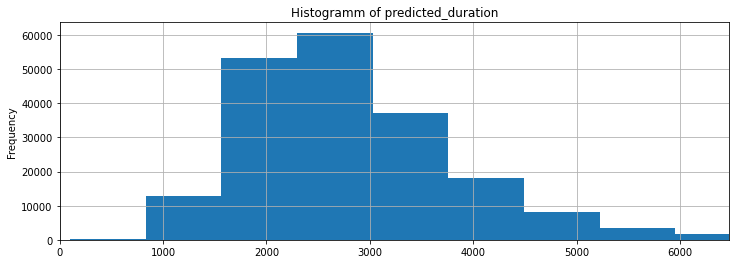

In [6]:
df['predicted_duration'] = df.actual_delivery_time - df.created_at
df.predicted_duration = df.predicted_duration.dt.seconds
df.predicted_duration =  df.predicted_duration.astype(float)

print("predicted_duration in seconds:")
print("\tmin:", df.predicted_duration.min())
q_099 = round(df.predicted_duration.quantile(q=0.99))
print("\tquantile_0.99:", q_099)
print("\tmax:", df.predicted_duration.max())
print("\tmean:", round(df.predicted_duration.mean()))
print("\tstd:", round(df.predicted_duration.std()))
df.predicted_duration.plot.hist(bins=100, grid=True, title="Histogramm of predicted_duration", figsize=(12, 4), xlim=(0, q_099))

## Select features

In [7]:
def print_info(df, col):
    print(f"\n{col}:")
    print("\tmin:", df[col].min())
    print("\tmax:", df[col].max())
    print("\tmean:", round(df[col].mean()))
    print("\tstd:", round(df[col].std()))
    print("\tcount  < 0:", df[df[col] < 0].shape[0])
    print("\tcount == 0:", df[df[col] == 0].shape[0])
    print("\tcount  NaN:", df[df[col].isnull()].shape[0])

def print_discrete_info(df, col):
    print(f"\n{col}:")
    print("\tmin:", df[col].min())
    print("\tmax:", df[col].max())
    print("\tcount  < 0:", df[df[col] < 0].shape[0])
    print("\tcount == 0:", df[df[col] == 0].shape[0])
    print("\tcount  NaN:", df[df[col].isnull()].shape[0])
    print("\tcount unique:", df[col].unique().shape[0])
    print("\tUnique:", df[col].unique())

def replace_nan_or_negative_by_zero_transform_to_type(df, col, col_type):
    df[col] = df[col].fillna(0)
    df[col] = df[col].apply(lambda x : x if x > 0 else 0)
    df[col] =  df[col].astype(col_type)

#### Market features
- Replace negative values by 0 (since number of dashers or orders can't be negative)
- Replace NaN by 0
- Transform to int

In [8]:
print_info(df, "total_onshift_dashers")
print_info(df, "total_busy_dashers")
print_info(df, "total_outstanding_orders")

no_any_market = df[ (df.total_onshift_dashers.isnull()) | (df.total_busy_dashers.isnull()) | (df.total_outstanding_orders.isnull()) ]
print("\nAny market features is NaN:", no_any_market.shape[0])
no_all_market = df[ (df.total_onshift_dashers.isnull()) & (df.total_busy_dashers.isnull()) & (df.total_outstanding_orders.isnull()) ]
print("All market features is NaN:", no_all_market.shape[0])

replace_nan_or_negative_by_zero_transform_to_type(df, "total_onshift_dashers", int)
replace_nan_or_negative_by_zero_transform_to_type(df, "total_busy_dashers", int)
replace_nan_or_negative_by_zero_transform_to_type(df, "total_outstanding_orders", int)

print("\nAfter replacement NaN or negative values by 0 and transformation to int")
print_info(df, "total_onshift_dashers")
print_info(df, "total_busy_dashers")
print_info(df, "total_outstanding_orders")


total_onshift_dashers:
	min: -4.0
	max: 171.0
	mean: 45
	std: 35
	count  < 0: 21
	count == 0: 3615
	count  NaN: 16262

total_busy_dashers:
	min: -5.0
	max: 154.0
	mean: 42
	std: 32
	count  < 0: 21
	count == 0: 4171
	count  NaN: 16262

total_outstanding_orders:
	min: -6.0
	max: 285.0
	mean: 58
	std: 53
	count  < 0: 44
	count == 0: 4111
	count  NaN: 16262

Any market features is NaN: 16262
All market features is NaN: 16262

After replacement NaN or negative values by 0 and transformation to int

total_onshift_dashers:
	min: 0
	max: 171
	mean: 41
	std: 35
	count  < 0: 0
	count == 0: 19898
	count  NaN: 0

total_busy_dashers:
	min: 0
	max: 154
	mean: 38
	std: 33
	count  < 0: 0
	count == 0: 20454
	count  NaN: 0

total_outstanding_orders:
	min: 0
	max: 285
	mean: 53
	std: 53
	count  < 0: 0
	count == 0: 20417
	count  NaN: 0


#### store_id, market_id
- Replace NaN by 0
- Transform to int

In [9]:
print_discrete_info(df, "store_id")
print_discrete_info(df, "market_id")

replace_nan_or_negative_by_zero_transform_to_type(df, "store_id", int)
replace_nan_or_negative_by_zero_transform_to_type(df, "market_id", int)

print("\nAfter replacement NaN by 0 and transformation to int")
print_discrete_info(df, "market_id")


store_id:
	min: 1
	max: 6987
	count  < 0: 0
	count == 0: 0
	count  NaN: 0
	count unique: 6743
	Unique: [1845 5477 2841 ...  215 2956 3630]

market_id:
	min: 1.0
	max: 6.0
	count  < 0: 0
	count == 0: 0
	count  NaN: 987
	count unique: 7
	Unique: [ 1.  2.  3.  4. nan  5.  6.]

After replacement NaN by 0 and transformation to int

market_id:
	min: 0
	max: 6
	count  < 0: 0
	count == 0: 987
	count  NaN: 0
	count unique: 7
	Unique: [1 2 3 4 0 5 6]


#### subtotal, estimated_store_to_consumer_driving_duration
- Replace NaN by 0
- Transform to float

In [10]:
print_info(df, "subtotal")
print_info(df, "estimated_store_to_consumer_driving_duration")

replace_nan_or_negative_by_zero_transform_to_type(df, "subtotal", float)
replace_nan_or_negative_by_zero_transform_to_type(df, "estimated_store_to_consumer_driving_duration", float)

print("\nAfter replacement NaN by 0 and transformation to float")
print_info(df, "estimated_store_to_consumer_driving_duration")


subtotal:
	min: 0
	max: 27100
	mean: 2682
	std: 1823
	count  < 0: 0
	count == 0: 179
	count  NaN: 0

estimated_store_to_consumer_driving_duration:
	min: 0.0
	max: 2088.0
	mean: 545
	std: 219
	count  < 0: 0
	count == 0: 9
	count  NaN: 526

After replacement NaN by 0 and transformation to float

estimated_store_to_consumer_driving_duration:
	min: 0.0
	max: 2088.0
	mean: 544
	std: 221
	count  < 0: 0
	count == 0: 535
	count  NaN: 0


## Add new features

In [117]:
df['created_at_hour'] = df.created_at.dt.hour
df['created_at_day_of_week'] = df.created_at.dt.day_of_week

In [105]:
#df.created_at.dt.day_of_week
#df.created_at.dt.hour
Counter(df.created_at.dt.hour)

Counter({14: 8821,
         13: 11464,
         12: 15560,
         18: 36973,
         19: 27068,
         16: 12669,
         17: 28187,
         11: 13541,
         20: 15250,
         15: 8163,
         21: 7095,
         10: 5100,
         22: 1417,
         9: 3413,
         8: 2109,
         7: 538,
         6: 40,
         23: 11,
         0: 2})

<AxesSubplot:title={'center':'Histogramm'}, ylabel='Frequency'>

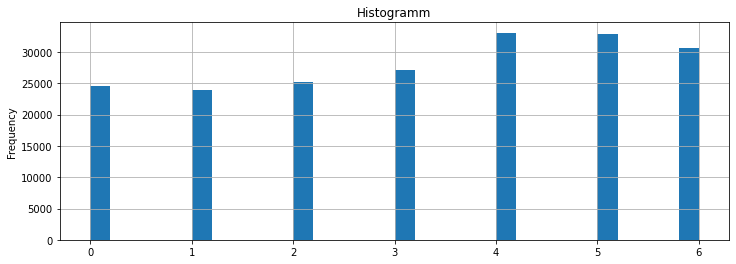

In [112]:
df.created_at.dt.day_of_week.plot.hist(bins=30, grid=True, title="Histogramm", figsize=(12, 4))

## Building Models

In [147]:
cols = ['market_id','store_id','subtotal','total_onshift_dashers','total_busy_dashers','total_outstanding_orders','estimated_store_to_consumer_driving_duration']
cols.append('created_at_hour')
cols.append('created_at_day_of_week')

X = df[cols]
y = df['predicted_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 177678
Test size: 19743


#### LinearRegression
Metrics: https://scikit-learn.org/stable/modules/classes.html#regression-metrics

In [150]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import sklearn.metrics as m

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'\nModel score: {model.score(X_train, y_train):.3f}')
#print('Model Coefficients:', model.coef_)
print(f'Model Intercept: {model.intercept_:.3f}')

print("\nMetrics:")
#print(f"{'mean_squared_error':35s}: {m.mean_squared_error(y_test, y_pred):8.1f}")
print(f"{'explained_variance_score':35s}: {m.explained_variance_score(y_test, y_pred):8.3f}")
print(f"{'Coefficient of determination':35s}: {m.r2_score(y_test, y_pred):8.3f}")
print(f"{'max_error':35s}: {m.max_error(y_test, y_pred):8.1f} sec.")
print(f"{'mean_absolute_error':35s}: {m.mean_absolute_error(y_test, y_pred):8.1f} sec.")
print(f"{'median_absolute_error':35s}: {m.median_absolute_error(y_test, y_pred):8.1f} sec.")
print(f"{'mean_poisson_deviance':35s}: {m.mean_poisson_deviance(y_test, y_pred):8.1f} sec.")
print(f"{'mean_absolute_percentage_error':35s}: {m.mean_absolute_percentage_error(y_test, y_pred):8.3f}")


Model score: 0.186
Model Intercept: 1736.892

Metrics:
explained_variance_score           :    0.197
Coefficient of determination       :    0.197
max_error                          :  33431.4 sec.
mean_absolute_error                :    708.9 sec.
median_absolute_error              :    563.8 sec.
mean_poisson_deviance              :    308.2 sec.
mean_absolute_percentage_error     :    0.268


#### RandomForestRegressor

In [199]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=20, random_state=10, n_estimators=100, criterion='mse', min_samples_split=50, min_samples_leaf=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'\nModel score: {model.score(X_train, y_train):.3f}')


Model score: 0.390


In [200]:
print("\nMetrics:")
#print(f"{'mean_squared_error':35s}: {m.mean_squared_error(y_test, y_pred):8.1f}")
print(f"{'explained_variance_score':35s}: {m.explained_variance_score(y_test, y_pred):8.3f}")
print(f"{'Coefficient of determination':35s}: {m.r2_score(y_test, y_pred):8.3f}")
print(f"{'max_error':35s}: {m.max_error(y_test, y_pred):8.1f} sec.")
print(f"{'mean_absolute_error':35s}: {m.mean_absolute_error(y_test, y_pred):8.1f} sec.")
print(f"{'median_absolute_error':35s}: {m.median_absolute_error(y_test, y_pred):8.1f} sec.")
print(f"{'mean_poisson_deviance':35s}: {m.mean_poisson_deviance(y_test, y_pred):8.1f} sec.")
print(f"{'mean_absolute_percentage_error':35s}: {m.mean_absolute_percentage_error(y_test, y_pred):8.3f}")


Metrics:
explained_variance_score           :    0.276
Coefficient of determination       :    0.276
max_error                          :  33465.2 sec.
mean_absolute_error                :    665.7 sec.
median_absolute_error              :    522.0 sec.
mean_poisson_deviance              :    272.7 sec.
mean_absolute_percentage_error     :    0.249


In [202]:
665//60

11

In [203]:
2862//60

47

In [204]:
708//60

11

In [24]:
import torch

split_rate = 0.9
num_train = round(dataset.shape[0] *split_rate)
num_valid = dataset.shape[0] - num_train

train_set, valid_set = torch.utils.data.random_split(dataset, [num_train, num_valid])
print("train_set size:", len(train_set))
print("valid_set size:", len(valid_set))

train_set size: 177679
valid_set size: 19742
